In [2]:
import os
import moviepy.editor as mp
from pydub import AudioSegment
import numpy as np
import librosa
import soundfile as sf

In [3]:
# 提取音频
def extract_audio_from_mp4(video_path):
    video = mp.VideoFileClip(video_path)
    audio = video.audio
    audio_path = video_path.rsplit('.', 1)[0] + '.wav'
    audio.write_audiofile(audio_path)
    return audio_path

In [7]:
audio_path = extract_audio_from_mp4('C:/Users/Liudong/Desktop/MyData/d18e5355d0684c6da2227527c8dadde1.mp4')

MoviePy - Writing audio in C:/Users/Liudong/Desktop/MyData/d18e5355d0684c6da2227527c8dadde1.wav


MoviePy - Done.


In [4]:
audio_path = extract_audio_from_mp4('C:/Users/Liudong/Desktop/MyData/对话.mp4')

MoviePy - Writing audio in C:/Users/Liudong/Desktop/MyData/对话.wav


MoviePy - Done.


In [9]:
# 音频合并
def merge_audio_with_length_of_b(audio_a_path, audio_b_path):
    audio_a = AudioSegment.from_file(audio_a_path)
    audio_b = AudioSegment.from_file(audio_b_path)
    # 创建 2 秒的空白音频
    silence = AudioSegment.silent(duration=2000)

    # 在音频 b 前后添加空白音频
    padded_audio_b = silence + audio_b + silence
    adjusted_audio_a = audio_a - 20

    # 取音频 b 的长度
    target_length = len(padded_audio_b)

    # 如果音频 a 长度大于音频 b，裁剪音频 a 到音频 b 的长度
    if len(adjusted_audio_a) > target_length:
        adjusted_audio_a = adjusted_audio_a[:target_length]

    adjusted_audio_b = padded_audio_b + 5

    mixed_audio = adjusted_audio_a.overlay(adjusted_audio_b)

    return mixed_audio

In [18]:
audio_a_path = "C:/Users/Liudong/Desktop/MyData/噪音视频.wav"
audio_b_path = "C:/Users/Liudong/Desktop/MyData/d18e5355d0684c6da2227527c8dadde1.wav"
audio_path = audio_a_path.rsplit('.', 1)[0] + '.wav'
mixed_audio = merge_audio_with_length_of_b(audio_a_path, audio_b_path)
mixed_audio.export("C:/Users/Liudong/Desktop/MyData/mixed_audio_with_length_of_b2.wav", format="wav")

<_io.BufferedRandom name='C:/Users/Liudong/Desktop/MyData/mixed_audio_with_length_of_b2.wav'>

In [29]:
# 谱减法降噪
'''
假设音频开始的一部分为噪声，用于估计噪声功率谱，然后进行谱减法降噪
'''
def spectral_subtraction_without_noise_file(audio_signal, window_size=2048, hop_length=512, alpha=2):
    stft = librosa.stft(audio_signal, n_fft=window_size, hop_length=hop_length)
    magnitude = np.abs(stft)
    phase = np.angle(stft)

    # 估计噪声功率谱（假设音频开始部分为噪声）
    noise_magnitude = magnitude[:, :window_size // hop_length]
    noise_mean_magnitude = np.mean(noise_magnitude, axis=-1, keepdims=True)

    # 谱减法降噪
    subtracted_magnitude = np.maximum(magnitude - alpha * noise_mean_magnitude, 0)

    # 重构降噪后的音频信号
    subtracted_stft = subtracted_magnitude * np.exp(1j * phase)
    denoised_signal = librosa.istft(subtracted_stft, hop_length=hop_length)

    return denoised_signal

In [30]:
# 加载音频文件（假设音频文件为 wav 格式）
audio_path = "C:/Users/Liudong/Desktop/MyData/mixed_audio_with_length_of_b.wav"
audio_signal, sample_rate = librosa.load(audio_path, sr=None)

# 进行谱减法降噪
denoised_audio = spectral_subtraction_without_noise_file(audio_signal)

# 保存降噪后的音频
output_path = "C:/Users/Liudong/Desktop/MyData/denoised_audio_without_noise_file.wav"
sf.write(output_path, denoised_audio, samplerate=sample_rate)

In [10]:
# 谱减法降噪
'''
具备噪声音频
'''
def spectral_subtraction(audio_signal, noise_signal, alpha=2):
    # 计算音频信号和噪声信号的短时傅里叶变换
    audio_stft = librosa.stft(audio_signal)
    noise_stft = librosa.stft(noise_signal)

    # 计算噪声功率谱
    noise_power = np.abs(noise_stft)**2

    # 计算音频功率谱
    audio_power = np.abs(audio_stft)**2

    # 估计噪声平均功率谱
    noise_mean_power = np.mean(noise_power, axis=-1, keepdims=True)

    # 谱减法降噪
    subtracted_power = np.maximum(audio_power - alpha * noise_mean_power, 0)

    # 计算降噪后的幅度谱
    subtracted_magnitude = np.sqrt(subtracted_power)

    # 重构降噪后的音频信号
    subtracted_stft = subtracted_magnitude * np.exp(1j * np.angle(audio_stft))
    denoised_signal = librosa.istft(subtracted_stft)

    return denoised_signal

In [11]:
# 加载音频文件
audio_path = "C:/Users/Liudong/Desktop/MyData/对话.wav"
noise_path = "C:/Users/Liudong/Desktop/MyData/噪音视频.wav"
audio_signal, _ = librosa.load(audio_path, sr=None)
noise_signal, _ = librosa.load(noise_path, sr=None)

# 进行谱减法降噪
denoised_audio = spectral_subtraction(audio_signal, noise_signal)
output_path = "C:/Users/Liudong/Desktop/MyData/denoised_audio_对话.wav"
sf.write(output_path, denoised_audio, samplerate=sample_rate)

In [7]:
# 维纳滤波
def wiener_filtering(audio_signal, noise_signal):
    # 计算音频信号和噪声信号的短时傅里叶变换
    audio_stft = librosa.stft(audio_signal)
    noise_stft = librosa.stft(noise_signal)

    # 计算噪声功率谱
    noise_power = np.abs(noise_stft)**2

    # 计算音频功率谱
    audio_power = np.abs(audio_stft)**2

    # 估计噪声平均功率谱
    noise_mean_power = np.mean(noise_power, axis=-1, keepdims=True)

    # 计算维纳滤波器系数
    filter_coeff = audio_power / (audio_power + noise_mean_power)

    # 应用维纳滤波器
    filtered_stft = filter_coeff * audio_stft

    # 重构降噪后的音频信号
    denoised_signal = librosa.istft(filtered_stft)

    return denoised_signal

In [9]:
# 加载音频文件（假设音频文件为 wav 格式）
audio_path = "C:/Users/Liudong/Desktop/MyData/对话.wav"
noise_path = "C:/Users/Liudong/Desktop/MyData/噪音视频.wav"
audio_signal, sample_rate = librosa.load(audio_path, sr=None)
noise_signal, _ = librosa.load(noise_path, sr=None)

# 进行维纳滤波降噪
denoised_audio = wiener_filtering(audio_signal, noise_signal)

# 保存降噪后的音频
output_path = "C:/Users/Liudong/Desktop/MyData/denoised_audio_wiener_filter_对话.wav"
sf.write(output_path, denoised_audio, samplerate=sample_rate)

In [13]:
import numpy as np
import pywt
import librosa
import soundfile as sf

def wavelet_denoising(audio_signal):
    # 进行小波分解
    coeffs = pywt.wavedec(audio_signal, 'db4', level=3)

    # 对高频系数进行阈值处理
    threshold = np.median(np.abs(coeffs[1])) / 0.6745
    coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]

    # 重构音频信号
    denoised_signal = pywt.waverec(coeffs, 'db4')

    return denoised_signal

# 加载音频文件（假设音频文件为 wav 格式）
audio_path = "C:/Users/Liudong/Desktop/MyData/对话.wav"
audio_signal, sample_rate = librosa.load(audio_path, sr=None)

# 进行小波变换降噪
denoised_audio = wavelet_denoising(audio_signal)

# 保存降噪后的音频
output_path = "C:/Users/Liudong/Desktop/MyData/denoised_audio_wavelet_denoising_对话.wav"
sf.write(output_path, denoised_audio, samplerate=sample_rate)

In [5]:
# 将wav文件调整为48000Hz采样率的单声道wav文件
import soundfile as sf

def convert_wav(input_file, output_file):
    data, samplerate = sf.read(input_file)
    # 如果是多声道，取第一个声道
    if len(data.shape) > 1:
        data = data[:, 0]
    sf.write(output_file, data, 48000)

input_filename = "C:/Users/Liudong/Desktop/MyData/对话.wav"
output_filename = "C:/Users/Liudong/Desktop/MyData/对话_simple.wav"
convert_wav(input_filename, output_filename)

In [4]:
import wave

def check_wav_properties(wav_file_path):
    with wave.open(wav_file_path, 'rb') as wav_file:
        num_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        frame_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        compression_type = wav_file.getcomptype()
        compression_name = wav_file.getcompname()

        print(f"Number of channels: {num_channels}")
        print(f"Sample width (in bytes): {sample_width}")
        print(f"Frame rate (Hz): {frame_rate}")
        print(f"Number of frames: {num_frames}")
        print(f"Compression type: {compression_type}")
        print(f"Compression name: {compression_name}")

wav_file_path = "C:/Users/Liudong/Desktop/MyData/mixed_audio_with_length_of_b2.wav"
check_wav_properties(wav_file_path)

Number of channels: 1
Sample width (in bytes): 2
Frame rate (Hz): 48000
Number of frames: 344421
Compression type: NONE
Compression name: not compressed


In [1]:
# DFSMN模型去噪
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks


ans = pipeline(
    Tasks.acoustic_noise_suppression,
    model='damo/speech_dfsmn_ans_psm_48k_causal')
result = ans(
    'https://modelscope.cn/api/v1/models/damo/speech_dfsmn_ans_psm_48k_causal/repo?Revision=master&FilePath=examples/speech_with_noise_48k.wav',
    output_path='output.wav')

c:\Users\Liudong\.conda\envs\dfsmn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-29 09:28:38,579 - modelscope - WARNING - Model revision not specified, use revision: v1.0.2
2024-10-29 09:28:38,846 - modelscope - INFO - initiate model from C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal
2024-10-29 09:28:38,847 - modelscope - INFO - initiate model from location C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal.
2024-10-29 09:28:38,850 - modelscope - INFO - initialize model from C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal
2024-10-29 09:28:38,863 - modelscope - WARNING - No preprocessor field found in cfg.
2024-10-29 09:28:38,863 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.

In [7]:
# DFSMN模型去噪
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks

ans = pipeline(
    Tasks.acoustic_noise_suppression,
    model='damo/speech_dfsmn_ans_psm_48k_causal')
result = ans(
    'C:/Users/Liudong/Desktop/MyData/mixed_audio_with_length_of_b2_simple.wav',
    output_path='output5.wav')

2024-11-04 09:20:31,944 - modelscope - WARNING - Model revision not specified, use revision: v1.0.2
2024-11-04 09:20:32,456 - modelscope - INFO - initiate model from C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal
2024-11-04 09:20:32,457 - modelscope - INFO - initiate model from location C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal.
2024-11-04 09:20:32,461 - modelscope - INFO - initialize model from C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal
2024-11-04 09:20:32,480 - modelscope - WARNING - No preprocessor field found in cfg.
2024-11-04 09:20:32,481 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2024-11-04 09:20:32,482 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': 'C:\\Users\\Liudong\\.cache\\modelscope\\hub\\damo\\speech_dfsmn_ans_psm_48k_causal'}. trying to b

In [16]:
import wave

def print_wave_info(file_path):
    with wave.open(file_path, 'rb') as audio_file:
        channels = audio_file.getnchannels()       # 声道数
        sample_width = audio_file.getsampwidth()   # 采样宽度
        frame_rate = audio_file.getframerate()     # 采样率
        frames = audio_file.getnframes()           # 总帧数
        duration = frames / float(frame_rate)      # 时长（秒）

        print("Channels:", channels)
        print("Sample Width (bytes):", sample_width)
        print("Frame Rate (Hz):", frame_rate)
        print("Number of Frames:", frames)
        print("Duration (seconds):", duration)

# 调用函数，传入音频文件路径
print_wave_info('output4.wav')


Channels: 1
Sample Width (bytes): 2
Frame Rate (Hz): 48000
Number of Frames: 319725
Duration (seconds): 6.6609375


In [17]:
from pydub import AudioSegment
from mutagen import File

def print_audio_detailed_info(file_path):
    audio = AudioSegment.from_file(file_path)
    audio_file = File(file_path)  # 用于提取元数据

    channels = audio.channels
    frame_rate = audio.frame_rate
    sample_width = audio.sample_width
    duration = len(audio) / 1000.0  # 时长（秒）
    bitrate = audio_file.info.bitrate / 1000 if audio_file.info.bitrate else "Unknown"  # 比特率 kbps
    sample_depth = audio.sample_width * 8  # 采样深度（位）

    print("Channels:", channels)
    print("Sample Width (bytes):", sample_width)
    print("Sample Depth (bits):", sample_depth)
    print("Frame Rate (Hz):", frame_rate)
    print("Duration (seconds):", duration)
    print("Bitrate (kbps):", bitrate)

    # 提取 ID3 元数据
    if audio_file.tags:
        print("\nMetadata (ID3 Tags):")
        for tag, value in audio_file.tags.items():
            print(f"{tag}: {value}")

# 调用函数，传入音频文件路径
print_audio_detailed_info('output4.wav')


Channels: 1
Sample Width (bytes): 2
Sample Depth (bits): 16
Frame Rate (Hz): 48000
Duration (seconds): 6.661
Bitrate (kbps): 768.0


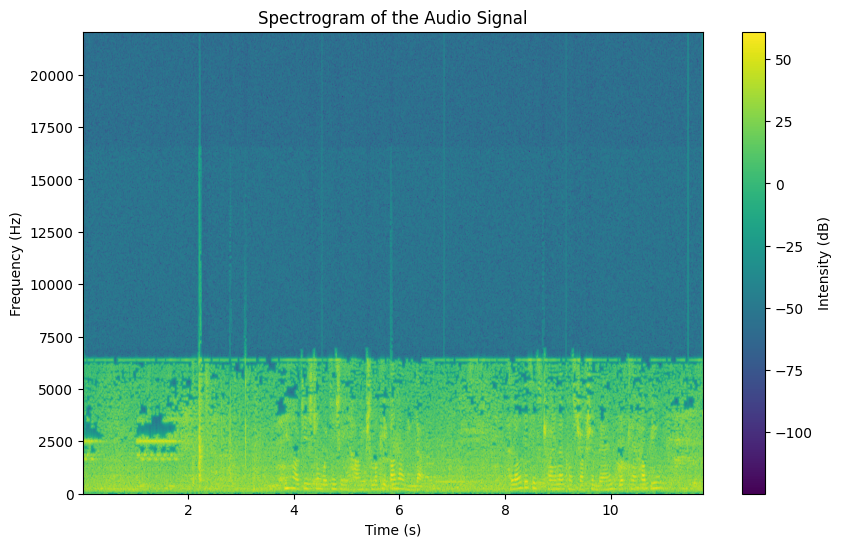

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# 读取音频文件
sample_rate, data = wavfile.read('C:/Users/Liudong/Desktop/MyData/对话.wav')

# 如果音频是立体声，将其转换为单声道
if data.ndim > 1:
    data = data.mean(axis=1)

# 绘制声谱图
plt.figure(figsize=(10, 6))
plt.specgram(data, NFFT=1024, Fs=sample_rate, noverlap=512, cmap='viridis', scale='dB')
plt.title('Spectrogram of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.show()


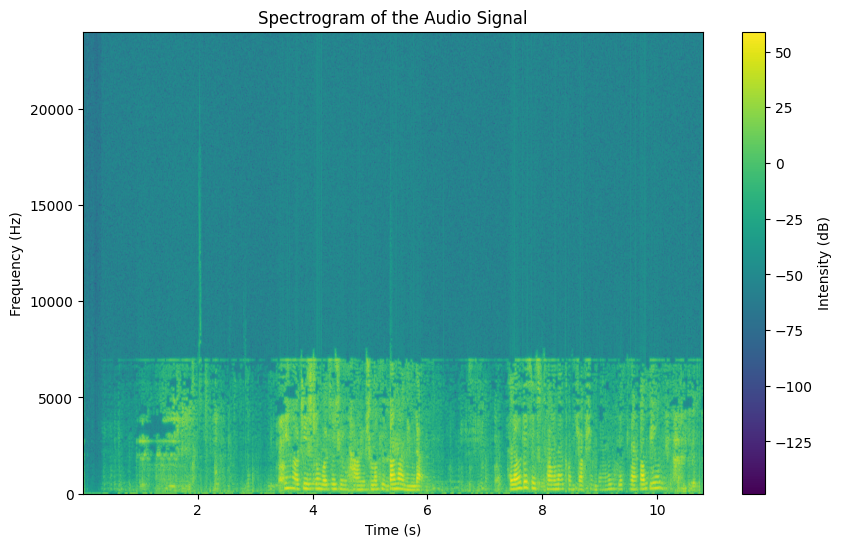

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# 读取音频文件
sample_rate, data = wavfile.read('output4.wav')

# 如果音频是立体声，将其转换为单声道
if data.ndim > 1:
    data = data.mean(axis=1)

# 绘制声谱图
plt.figure(figsize=(10, 6))
plt.specgram(data, NFFT=1024, Fs=sample_rate, noverlap=512, cmap='viridis', scale='dB')
plt.title('Spectrogram of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.show()

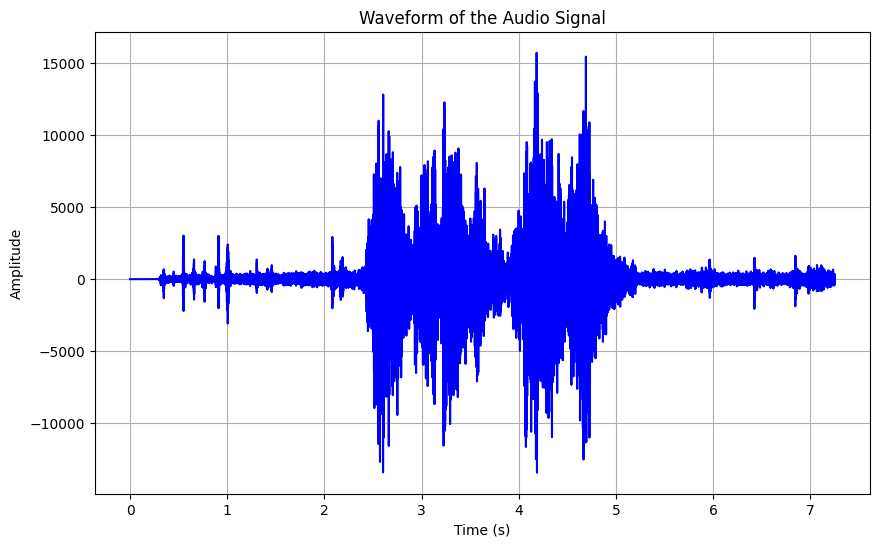

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# 读取音频文件
sample_rate, data = wavfile.read('C:/Users/Liudong/Desktop/MyData/mixed_audio_with_length_of_b2.wav')

# 如果音频是立体声，将其转换为单声道
if data.ndim > 1:
    data = data.mean(axis=1)

# 创建时间轴
time = np.linspace(0, len(data) / sample_rate, num=len(data))

# 绘制波形图
plt.figure(figsize=(10, 6))
plt.plot(time, data, color='blue')
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


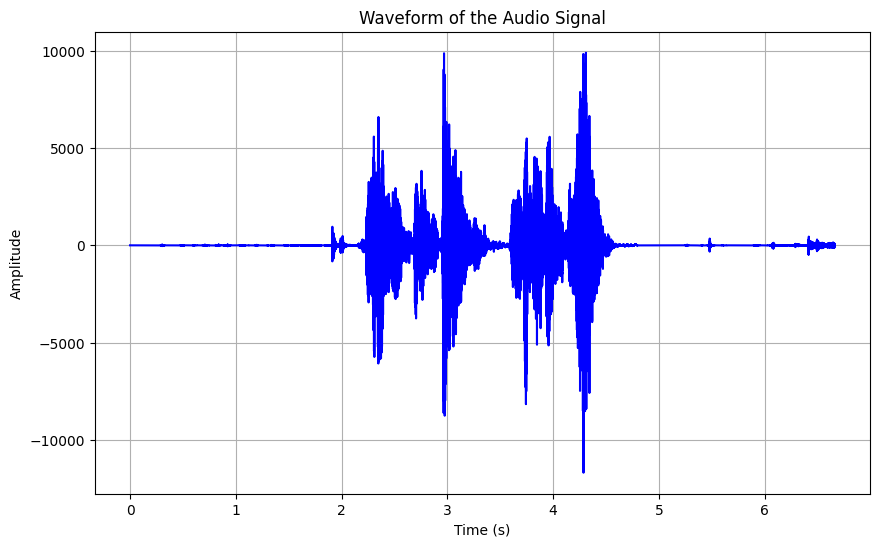

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# 读取音频文件
sample_rate, data = wavfile.read('output5.wav')

# 如果音频是立体声，将其转换为单声道
if data.ndim > 1:
    data = data.mean(axis=1)

# 创建时间轴
time = np.linspace(0, len(data) / sample_rate, num=len(data))

# 绘制波形图
plt.figure(figsize=(10, 6))
plt.plot(time, data, color='blue')
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

import soundfile
from IPython.display import display, Audio
mixwav_mc, sr = soundfile.read("output5.wav")
# mixwav.shape: num_samples, num_channels
mixwav_sc = mixwav_mc[1]
display(Audio(mixwav_mc.T, rate=sr))

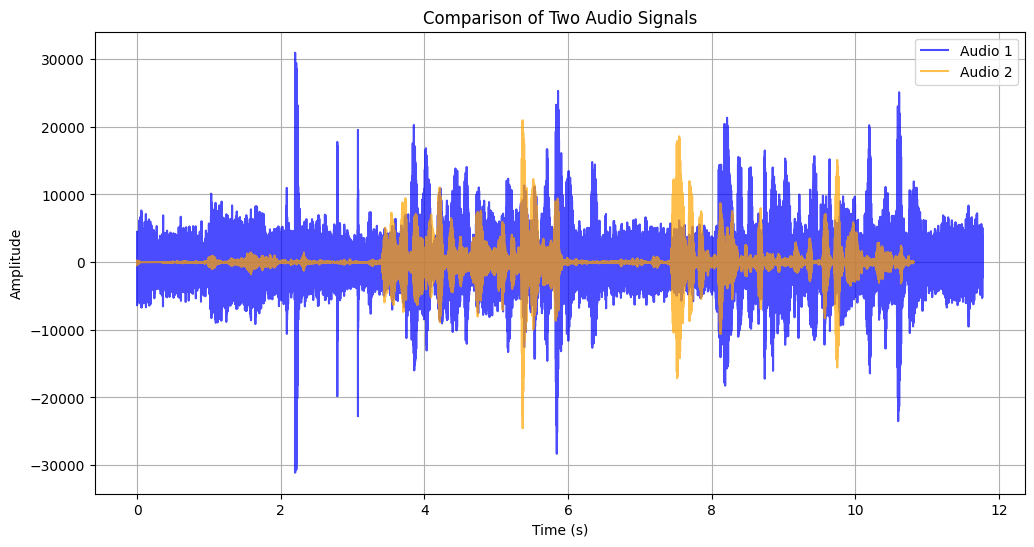

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# 读取第一个音频文件
sample_rate1, data1 = wavfile.read('C:/Users/Liudong/Desktop/MyData/对话.wav')
if data1.ndim > 1:
    data1 = data1.mean(axis=1)

# 读取第二个音频文件
sample_rate2, data2 = wavfile.read('output4.wav')
if data2.ndim > 1:
    data2 = data2.mean(axis=1)

# 创建第一个音频的时间轴
time1 = np.linspace(0, len(data1) / sample_rate1, num=len(data1))

# 创建第二个音频的时间轴
time2 = np.linspace(0, len(data2) / sample_rate2, num=len(data2))

# 绘制两个音频的波形在同一张图上
plt.figure(figsize=(12, 6))
plt.plot(time1, data1, label='Audio 1', color='blue', alpha=0.7)
plt.plot(time2, data2, label='Audio 2', color='orange', alpha=0.7)
plt.title('Comparison of Two Audio Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
import numpy as np

def calculate_snr(clean_signal, denoised_signal):
    # 计算信号和噪声的能量
    signal_power = np.sum(clean_signal ** 2)
    noise_power = np.sum((clean_signal - denoised_signal) ** 2)
    
    # 计算 SNR，以 dB 为单位
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# 示例使用
clean_signal = np.array(sample_rate2)
denoised_signal = np.array(sample_rate1)
snr_value = calculate_snr(clean_signal, denoised_signal)
print(f"SNR: {snr_value:.2f} dB")


SNR: nan dB


In [12]:
# DFSMN模型去噪
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks

def denoising(path):
    ans = pipeline(
        Tasks.acoustic_noise_suppression,
        model='damo/speech_dfsmn_ans_psm_48k_causal')
    result = ans(
        path,
        output_path='output5.wav')

In [14]:
path = 'C:/Users/Liudong/Desktop/MyData/mixed_audio_with_length_of_b2_simple.wav'
denoising(path)

2024-11-04 09:25:21,220 - modelscope - WARNING - Model revision not specified, use revision: v1.0.2
2024-11-04 09:25:21,497 - modelscope - INFO - initiate model from C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal
2024-11-04 09:25:21,498 - modelscope - INFO - initiate model from location C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal.
2024-11-04 09:25:21,501 - modelscope - INFO - initialize model from C:\Users\Liudong\.cache\modelscope\hub\damo\speech_dfsmn_ans_psm_48k_causal
2024-11-04 09:25:21,521 - modelscope - WARNING - No preprocessor field found in cfg.
2024-11-04 09:25:21,522 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2024-11-04 09:25:21,523 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': 'C:\\Users\\Liudong\\.cache\\modelscope\\hub\\damo\\speech_dfsmn_ans_psm_48k_causal'}. trying to b